In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import yaml
import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
timesteps = 100
dt = 1e-3
tau_syn = 5e-3
tau_mem = 20e-3

neuron_params = {
        "threshold": 1.0,
        "i_offset": 0.0,
        "reset": "reset_to_v_reset",
        "dt": dt,
        "tau_mem": tau_mem,
        "tau_syn": tau_syn,
    }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# dims = [196, 10, 2]
dims = [196, 10, 2]
gains = np.array([3, 2]) * 1e0
# gains = np.array([10, 16]) * 1e-0
np.random.seed(42)
use_loss = True

# input_spike_times = {
#     n: np.where(
#         np.random.poisson(lam=0.2, size=(timesteps - 1)).clip(0, 1).astype(int)
#     )[0].tolist()
#     for n in range(dims[0])
# }
input_spike_times = {
    k: np.random.choice(np.arange(timesteps), size=1) for k in range(dims[0])
}
# input_spike_times = {
#     0 : [0]
# }

# input_spike_times = {
#     0: [19, 37, 52, 64, 78, 90, 99],
#     1: [17, 31, 42, 53, 65, 81, 92],
#     2: [19, 33, 46, 62, 76, 90, 99],
#     3: [17, 31, 46, 60, 73, 88],
#     4: [15, 39, 56, 65, 78, 88, 94],
#     5: [15, 32, 46, 60, 72, 82, 93],
#     6: [18, 33, 53, 63, 73, 84, 92],
#     7: [12, 24, 35, 48, 64, 76, 90],
#     8: [16, 31, 47, 62, 78, 93],
#     9: [16, 30, 44, 56, 66, 79, 92],
# }

print(input_spike_times)
input_spikes = np.zeros((timesteps, 1, dims[0]))
for n, times in input_spike_times.items() : 
    input_spikes[times, 0, n] = 1

input_spikes = torch.from_numpy(input_spikes).float().to(device)

{0: array([51]), 1: array([92]), 2: array([14]), 3: array([71]), 4: array([60]), 5: array([20]), 6: array([82]), 7: array([86]), 8: array([74]), 9: array([74]), 10: array([87]), 11: array([99]), 12: array([23]), 13: array([2]), 14: array([21]), 15: array([52]), 16: array([1]), 17: array([87]), 18: array([29]), 19: array([37]), 20: array([1]), 21: array([63]), 22: array([59]), 23: array([20]), 24: array([32]), 25: array([75]), 26: array([57]), 27: array([21]), 28: array([88]), 29: array([48]), 30: array([90]), 31: array([58]), 32: array([41]), 33: array([91]), 34: array([59]), 35: array([79]), 36: array([14]), 37: array([61]), 38: array([61]), 39: array([46]), 40: array([61]), 41: array([50]), 42: array([54]), 43: array([63]), 44: array([2]), 45: array([50]), 46: array([6]), 47: array([20]), 48: array([72]), 49: array([38]), 50: array([17]), 51: array([3]), 52: array([88]), 53: array([59]), 54: array([13]), 55: array([8]), 56: array([89]), 57: array([52]), 58: array([1]), 59: array([83]

In [5]:
from eventprop.models import SNN

In [6]:
model_config = {
    "T": timesteps,
    "dt": dt,
    "tau_m": tau_mem,
    "tau_s": tau_syn,
    "mu": 1.,
    "resolve_silent": False,
    "device": device,
    "get_first_spikes": False,
    "model_type" : "eventprop",
    "reset_to_zero" : True
}


In [7]:
eventprop_model = SNN(dims, **model_config)
layers = eventprop_model.layers
for layer, gain in zip(layers, gains) : 
    n2, n1 = layer.weight.shape
    nu = 1. / np.sqrt(n1)
    layer.weight.data = torch.from_numpy(np.random.normal(nu, nu, size=(n1, n2))).T.float() * gain
    # layer.weight.data = torch.ones((n2, n1)).float() * gain
eventprop_model.to(device)

SNN(
  (layers): RecordingSequential(
    (0): SpikingLinear_ev(196, 10)
    (1): SpikingLinear_ev(10, 2)
  )
)

In [8]:
packs = []
input = input_spikes.to(device)	
for layer in layers : 
    pack, _ = layer.manual_forward(input)
    packs.append(pack)
    input = pack[-1]

In [9]:
(inputs, Vs, V_spikes, Is, all_out_spikes) = list(zip(*packs))

In [10]:
all_spike_times = {}
for layer_id, (out_spikes, dim) in enumerate(zip(all_out_spikes, dims[1:])) : 
    all_spike_times[layer_id] = {}
    
    spike_times = torch.where(out_spikes[:, 0])
    spike_times = {
        n : spike_times[0][spike_times[1] == n].cpu().data.numpy() for n in range(dim)
    }
    spike_times
    first_spike_times = {
        n : spike_times[n][0] if len(spike_times[n]) > 0 else -1 for n in range(dim)
    }
    first_spikes_only = torch.zeros_like(out_spikes)
    for n in range(dim) : 
        if first_spike_times[n] > 0 : 
            first_spikes_only[first_spike_times[n], 0, n] = 1
    all_spike_times[layer_id]["all"] = spike_times
    all_spike_times[layer_id]["first"] = first_spike_times

In [11]:
LOSS_ALPHA = 3e-3
LOSS_TAU_0 = 5e-4
LOSS_TAU_0_INV = 1. / LOSS_TAU_0
LOSS_TAU_1 = 6.4e-3
LOSS_DT = 1e-3
LOSS_DT_TAU_0_RATIO = LOSS_DT / LOSS_TAU_0
LOSS_DT_TAU_1_RATIO = LOSS_DT / LOSS_TAU_1
LOSS_ALPHA_TAU_1_RATIO = LOSS_ALPHA / LOSS_TAU_1

In [12]:
first_spike_times

{0: 66, 1: 22}

In [13]:
if False :
    labels = 0
    first_spike_errors = {
        n : 0 for n in range(dims[1])
    }
    t_l = first_spike_times[labels]
    sum0 = 0
    for n in range(dims[-1]) : 
        if first_spike_times[n] != -1 : 
            sum0 += np.exp(-(first_spike_times[n] ) * LOSS_DT_TAU_0_RATIO)
        
    label_error = LOSS_TAU_0_INV * (1 - np.exp(-t_l * LOSS_DT_TAU_0_RATIO) / sum0) + LOSS_ALPHA_TAU_1_RATIO * np.exp(t_l * LOSS_DT_TAU_1_RATIO)
    first_spike_errors[labels] += label_error
    for n in range(dims[-1]) : 
        if first_spike_times[n] != -1 and labels != n: 
            first_spike_errors[n] = -LOSS_TAU_0_INV * (1 / sum0) * np.exp(-(first_spike_times[n]) * LOSS_DT_TAU_0_RATIO) 
else : 
    label = 0
    first_spike_errors = {
        n : 1 if n == label else -1 for n in range(dims[-1])
    }

In [14]:
first_spike_grads = torch.cat(list({
    n : spikes * error for spikes, (n, error) in zip(first_spikes_only.split(1, dim=-1), first_spike_errors.items())
}.values()), -1)

In [15]:
bw_packs = []
grads = first_spike_grads
for layer, pack in zip(layers[::-1], packs[::-1]) :         
    bw_pack = layer.manual_backward(grads, pack)
    grads = bw_pack[0]
    bw_packs.append(bw_pack)


In [16]:
grad_inputs, grad_weights, lVs, lIs = list(zip(*bw_packs[::-1]))

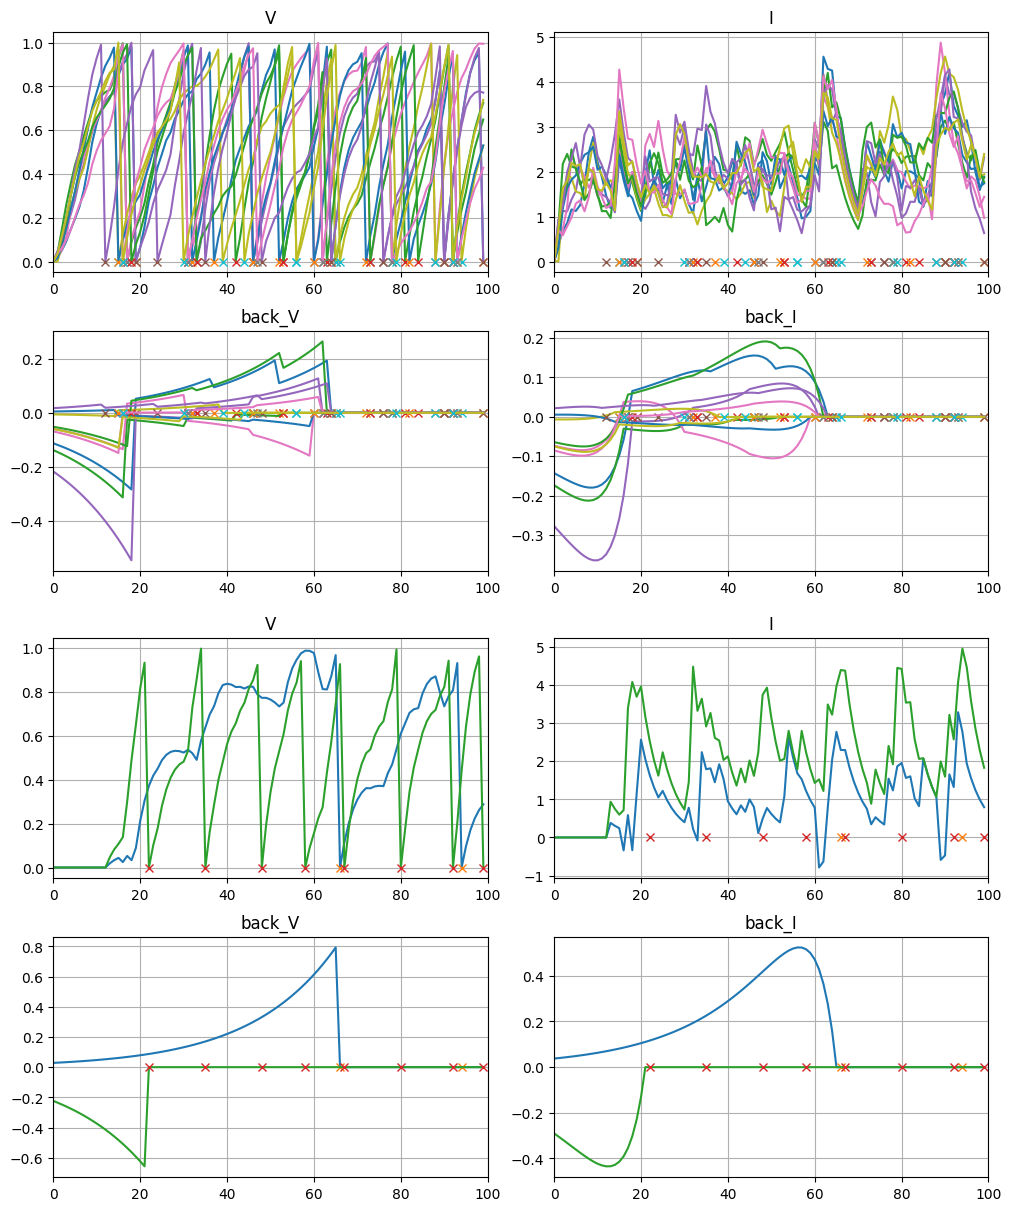

In [17]:
fig = plt.figure(figsize=(10, 12), constrained_layout=True)
subfigs = fig.subfigures(2, 1)

for subfig, V, I, lV, lI, spike_times, dim in zip(subfigs, Vs, Is, lVs, lIs, all_spike_times.values(), dims[1:]) :
    axs = subfig.subplots(2, 2)
    for ax, data, title in zip(axs.T.flatten(), [V, lV, I, lI], ["V", "back_V", "I", "back_I"]) : 
        for n in range(dim) : 
            ax.plot(data[:, 0, n].cpu().data.numpy(), label=f"neuron {n}")
            ax.plot(spike_times['all'][n], np.zeros_like(spike_times['all'][n]), "x", label=f"spike {n}")
        ax.set_title(title)
        ax.grid(visible=True)
        ax.set_xlim(0, timesteps)

In [18]:
lVs[-1].squeeze().cpu().data.numpy()[::-1][:, 0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.7929032 ,
       0.753258  , 0.71559507, 0.6798153 , 0.6458245 , 0.61353326,
       0.5828566 , 0.55371374, 0.52602804, 0.49972662, 0.4747403 ,
       0.45100328, 0.42845312, 0.40703046, 0.38667893, 0.36734498,
       0.3489777 , 0.3315288 , 0.31495237, 0.29920474, 0.2842445 ,
       0.2700323 , 0.25653067, 0.24370414, 0.23151892, 0.21994297,
       0.20894583, 0.19849853, 0.1885736 , 0.17914492, 0.17018767,
       0.16167828, 0.15359437, 0.14591466, 0.13861893, 0.13168798,
       0.12510358, 0.1188484 , 0.11290598, 0.10726068, 0.10189

In [19]:
Vs[-1][:, 0, 0].cpu().data.numpy()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01907922, 0.03338863,
       0.0439299 , 0.02474763, 0.05281444, 0.03343623, 0.08905519,
       0.21300933, 0.30508438, 0.37201056, 0.41915438, 0.4507921 ,
       0.48940808, 0.51386213, 0.5273086 , 0.5322548 , 0.5306914 ,
       0.52419627, 0.53700715, 0.5210962 , 0.4909995 , 0.5784192 ,
       0.639074  , 0.6978602 , 0.73555905, 0.7949064 , 0.8320613 ,
       0.8380175 , 0.8341641 , 0.8228938 , 0.823868  , 0.81636965,
       0.8254964 , 0.8241777 , 0.7887134 , 0.77377707, 0.77376693,
       0.76602155, 0.75247484, 0.7346546 , 0.75181645, 0.84579057,
       0.908753  , 0.9475169 , 0.97653055, 0.98881567, 0.98826414,
       0.9779624 , 0.8896106 , 0.8135671 , 0.8120645 , 0.8734827 ,
       0.96855664, 0.        , 0.11483406, 0.20095961, 0.26440543,
       0.30998018, 0.34151718, 0.36207014, 0.36127624, 0.36979

In [20]:
all_spike_times

{0: {'all': {0: array([19, 37, 52, 64, 78, 90, 99]),
   1: array([17, 31, 42, 53, 65, 81, 92]),
   2: array([19, 33, 46, 62, 76, 90, 99]),
   3: array([17, 31, 46, 60, 73, 88]),
   4: array([15, 39, 56, 65, 78, 88, 94]),
   5: array([15, 32, 46, 60, 72, 82, 93]),
   6: array([18, 33, 53, 63, 73, 84, 92]),
   7: array([12, 24, 35, 48, 64, 76, 90]),
   8: array([16, 31, 47, 62, 78, 93]),
   9: array([16, 30, 44, 56, 66, 79, 92])},
  'first': {0: 19,
   1: 17,
   2: 19,
   3: 17,
   4: 15,
   5: 15,
   6: 18,
   7: 12,
   8: 16,
   9: 16}},
 1: {'all': {0: array([66, 94]), 1: array([22, 35, 48, 58, 67, 80, 92, 99])},
  'first': {0: 66, 1: 22}}}

In [21]:
{
    n : V_spikes[0][..., n][times] for n, times in all_spike_times[0]["all"].items()
}

{0: tensor([[1.0088],
         [1.0239],
         [1.0021],
         [1.1449],
         [1.0596],
         [1.0155],
         [1.0002]], device='cuda:0', grad_fn=<IndexBackward0>),
 1: tensor([[1.0373],
         [1.0191],
         [1.0312],
         [1.0829],
         [1.0267],
         [1.0487],
         [1.0927]], device='cuda:0', grad_fn=<IndexBackward0>),
 2: tensor([[1.0295],
         [1.0376],
         [1.0336],
         [1.1235],
         [1.0045],
         [1.0298],
         [1.0428]], device='cuda:0', grad_fn=<IndexBackward0>),
 3: tensor([[1.0263],
         [1.0104],
         [1.0187],
         [1.0573],
         [1.0373],
         [1.1429]], device='cuda:0', grad_fn=<IndexBackward0>),
 4: tensor([[1.0038],
         [1.0007],
         [1.0006],
         [1.0096],
         [1.0902],
         [1.1269],
         [1.0632]], device='cuda:0', grad_fn=<IndexBackward0>),
 5: tensor([[1.0474],
         [1.0064],
         [1.0062],
         [1.0543],
         [1.0376],
         [1.0414

In [22]:
all_spike_times[0]["all"]

{0: array([19, 37, 52, 64, 78, 90, 99]),
 1: array([17, 31, 42, 53, 65, 81, 92]),
 2: array([19, 33, 46, 62, 76, 90, 99]),
 3: array([17, 31, 46, 60, 73, 88]),
 4: array([15, 39, 56, 65, 78, 88, 94]),
 5: array([15, 32, 46, 60, 72, 82, 93]),
 6: array([18, 33, 53, 63, 73, 84, 92]),
 7: array([12, 24, 35, 48, 64, 76, 90]),
 8: array([16, 31, 47, 62, 78, 93]),
 9: array([16, 30, 44, 56, 66, 79, 92])}

In [23]:
{n : I[spike_times[n]  , 0, n].cpu().data.numpy() for n in range(dims[1])}

KeyError: 0

In [ ]:
{n : V[spike_times[n] - 1, 0, n].cpu().data.numpy() for n in range(dims[1])}

{0: array([0.9429656, 0.955275 , 0.9814976], dtype=float32)}